# USGS Data Analysis Pre-and-Post Fire after the 2017 Wine Country Fires
### Author: Dr. Michelle Newcomer, LBNL
### Contact Info: mnewcomer@lbl.gov
### Date: July 16, 2018

In [15]:
library(dataRetrieval)
library(EGRET)
library(zoo)
library(leaflet)
library(dplyr)
library(ggplot2)
library(htmlwidgets)
library(IRdisplay)

## Introduction

Today we are going to explore the impact our the recent 2017 North Bay Wine Country wildfires on the health of the Russian River. The Russian River is a critical source of water for drinking water, riparian vegetation, ecosystem habitat, and food-web (fish and animals). The river also provides a critical source of water for agriculture, wineries, and recreation. Local populations use the River and watershed areas produced from it for fishing, recreation and over 600,000 residents use the filtered drinking water from the river every day. As scientists interested in the health of our local communities and environment, it is important we understand how climate conditions and natural disasters impact our resources. 


![Wine Country Fires](https://i.imgur.com/DqkOhjw.png)

The full impact of these fires can be visualized with many online image and map sources. Drone imagery is available showing urban, sub-urban, and rural areas pre-and-post fire. Many portions of the Russian River and tributaries flow through these burned zones such as Mark West Creek in Santa Rosa, and the Northern Russian River in Ukiah, California. Below are some links to drone imagery, GIS data layers, and publically available USGS datasets.

Drone Imagery: https://www.sonomasheriff.org/tubbscomplexlnu-fire-imagery
GIS Layers: https://sonomalandtrust.maps.arcgis.com/apps/    
Short link: https://arcg.is/1nqavf
Data Source: https://maps.waterdata.usgs.gov/ 


## Our Research at LBNL


In Oct. 2017, days after the fire started, my team and I at Lawrence Berkeley National Lab in collaboration with the Sonoma County Water Agency (http://www.scwa.ca.gov/) and our USGS-Boulder colleagues, launched the Sonoma County Post-Fire Water Quality Sampling Program to assess the potential for changes in river conditions after the fire. 
    
More information about the program can be found at our website: http://newscenter.lbl.gov/2017/11/20/research-becomes-reality-in-study-of-fire-impact-on-sonoma-water-resources/


![Berkeley Lab Sampling](https://i.imgur.com/72gLPcV.png)

## USGS Data Analysis

We are going to use the API functions built by the USGS to retrieve the publically available data automatically within this interactive Jupyter Notebook. We are going to choose a site that is downstream of the fire perimeters to look at how pH (a measure of acidity) has changed before and after the fire. All publically avaialble USGS data can be accessed directly through their site mapper https://maps.waterdata.usgs.gov/mapper/index.html. We provide an interactive method here to access this data within this notebook. 



## Functions to Interactively Retrieve Daily Data

We are going to use functions to automatically retrieve the data using a few inputs such as parameter codes, starting and ending dates, and the site number. Highlight all of the code for the entire function and press run. Functions take these type of input values and provide output in a neat and organized format. 


In [3]:

###############=======Functions to retrieve the daily data. Must be run as an entire cell============##########


getFlowDaily<-function (siteNumber, parameterCd = "00060", startDate = "", endDate = "", interactive = TRUE, convert = TRUE,statCd) {
  #statCd <- ifelse("00060" == parameterCd, "00003", "00001")
  url <- dataRetrieval::constructNWISURL(siteNumber, parameterCd, startDate, endDate, "dv", statCd, format = "tsv")
  data <- dataRetrieval::importRDB1(url, asDateTime = FALSE)
  if (nrow(data) > 0) {
    names(data) <- c("agency", "site", "dateTime", "value", "code")
    data$dateTime <- as.Date(data$dateTime)
  }
  qConvert <- ifelse("00060" == parameterCd, 35.314667, 1)
  qConvert <- ifelse(convert, qConvert, 1)
  indx<-which(is.na(data$value))
  data$value[indx]<-(data$value[indx-2]+data$value[indx-3])/2
  localDaily <- populateDaily(data, qConvert, interactive = interactive)
  return(localDaily)
}


getWQDaily<-function (siteNumber, parameterCd = "00060", startDate = "", endDate = "", interactive = TRUE, convert = TRUE,statCd) {
  statCd <- ifelse("00060" == parameterCd, "00003", "00001")
  url <- dataRetrieval::constructNWISURL(siteNumber, parameterCd, startDate, endDate, "dv", statCd = statCd, format = "tsv")
  data <- dataRetrieval::importRDB1(url, asDateTime = FALSE)
  indx<-nrow(data )
  if(indx < 2) {
    return(NA)
  } else{names(data) <- c("agency", "site", "dateTime", "value", "code")
  data$dateTime <- as.Date(data$dateTime)
  }
  
  if("63680" == parameterCd){
    data[is.na(data[,4]),4]<-as.numeric(data[is.na(data[,4]),6])
  }
  
  data[,4]<-as.numeric(data[,4])
  
  
  qConvert <- ifelse("00060" == parameterCd, 35.314667, 1)
  qConvert <- ifelse(convert, qConvert, 1)
  data<-transform(data, value = na.locf(value)) #means last observation carried forward when NA found
  indx<-which(data$value<0.01)
  
  if(length(indx)>1) {
    data$value[indx]<-NA
    data<-transform(data, value = na.locf(value)) #some Q is <0 so label as NA then used last observation
  }else{data<-data}
  
  localDaily <- populateDaily(data, qConvert, interactive = FALSE)
  localDaily$Day<-as.numeric(format.Date(localDaily$Date,format="%j"))
  return(localDaily)
}



##################=======End of Functions to retrieve the daily data============##########

## Gather water quality data for the Guerneville Station

Even though Guerneville is not directly inside a fire-perimeter, it is still a fire-impacted site because the watershed drains water from all of the fire-zones through streams and tributaries that eventually merge into the Russian River. Since Guerneville receives so much water that has traveled through these fire-impacted areas, the water qualtiy will reflect the history of its travel path.

We will use the site called RUSSIAN R NR GUERNEVILLE CA  with site ID "11467000" 

Many variables are available at this station including discharge, temperature, pH, dissolved oxygen, and alkalinity.Here is the list of all United States Geological Survey (USGS) optional parameters: https://help.waterdata.usgs.gov/codes-and-parameters/parameters

Click on the HTML for "Physical parameters" and find	pH, water, unfiltered, field, standard units. Take note of the five-digit code for pH which is "00400". We will need this when we go to fetch our data.



## Prepare input values

In [4]:
############################### Station 1: Gather water quality data and Prepare the input values:==============###########

#Now we can fetch the specific data for pre and post-fire from Guerneville.

# Specify the site #1: Fill in the ? with the site number for Guerneville
siteID <- "11467000" #Guerneville, CA

startDate <- "" #Gets earliest date 2009-06-01
endDate <- "2018-07-11" #Gets data up until Jan 24 2018

#### Specify the parameter code  for the water quality and fetch pH data: 

parameter_cd<-"00400" #5 digit USGS code for pH. Place number within quotes, no spaces




## Fetch Data using the USGS API and our input values

In [5]:
#Fetch daily water quality data: pH 
DailypH_1 <- getWQDaily(siteID,parameter_cd,startDate,endDate)
names(DailypH_1)<-c("Date","pH","Julian","Month","Day","DecYear","MonthSeq","waterYear","Qualifier","i","Log","Q7","Q30")


## Take a look at the data

In [6]:
head(DailypH_1)

Date,pH,Julian,Month,Day,DecYear,MonthSeq,waterYear,Qualifier,i,Log,Q7,Q30
2002-01-25,7.7,55541,1,25,2002.067,1825,2002,A:[0],1,2.041220,NA,NA
2002-01-26,7.9,55542,1,26,2002.070,1825,2002,A:[0],2,2.066863,NA,NA
2002-01-27,7.9,55543,1,27,2002.073,1825,2002,A:[0],3,2.066863,NA,NA
2002-01-28,7.9,55544,1,28,2002.075,1825,2002,A:[0],4,2.066863,NA,NA
2002-01-29,7.9,55545,1,29,2002.078,1825,2002,A:[0],5,2.066863,NA,NA
2002-01-30,7.9,55546,1,30,2002.081,1825,2002,A:[0],6,2.066863,NA,NA


## What do all of these components of the code mean?
### Name definitions

Date-Actual date

pH- values for the the variable pH which is acidity
    
Julian-day of the year
    
Month-Month labeled as a number Jan=1, Feb=2
    
Day-Day of the month
    
DecYear-Date converted to a decimal
    
MonthSeq-Number of months after 1850
    
waterYear- hydrological years begin in September. (Sept 2015-August 2016 is the 2016 water year)
    
Qualifier-quality codes
    
i-measuremen number
    
log-log of the data values
    
Q7-7 day running average
    
Q30-30 day running average

## Plot the pH data by month

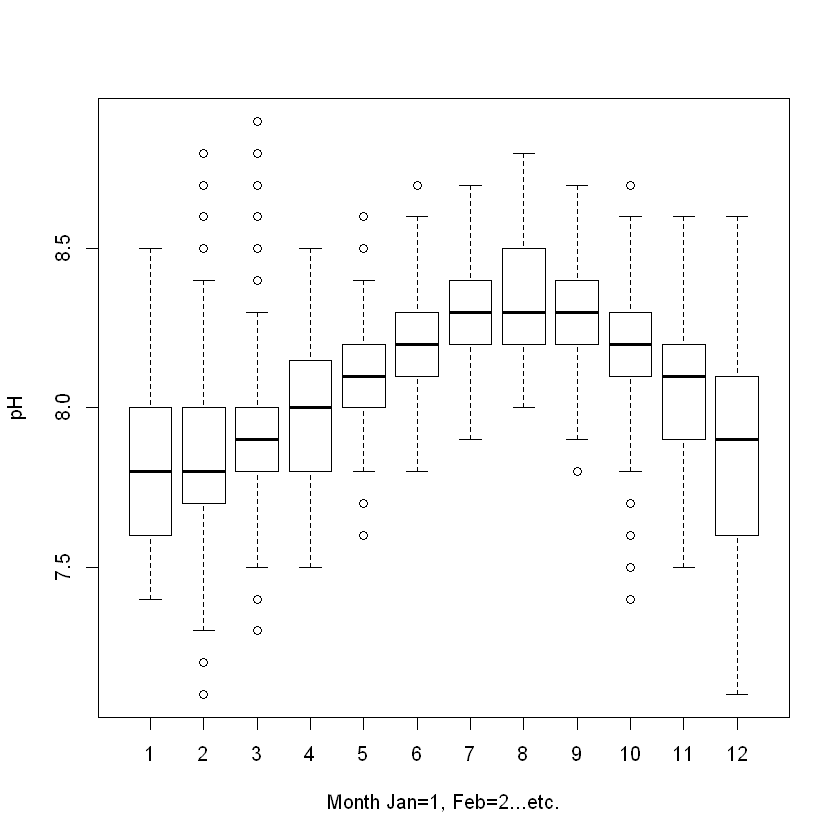

In [7]:

#######################================Plot the pH data by month============##########

boxplot(DailypH_1$pH~DailypH_1$Month,xlab="Month Jan=1, Feb=2...etc.",ylab="pH")



## Classify the pH data

In [8]:
#######################================Classify the pH data============##########
#Here we are going to categorize our dates as pre-fire and post-fire
#What does it mean to categorize in this way?
DailypH_1$prepost<-NA
DailypH_1$prepost[DailypH_1$Date < "2017-09-30"]<-"preFire" #dates before Sept. 30, 2017 are 0 for pre
DailypH_1$prepost[DailypH_1$Date > "2017-09-30"]<-"postFire" #dates after Sept. 30, 2017 are 1 for post

## Plot pre-and-post fire pH

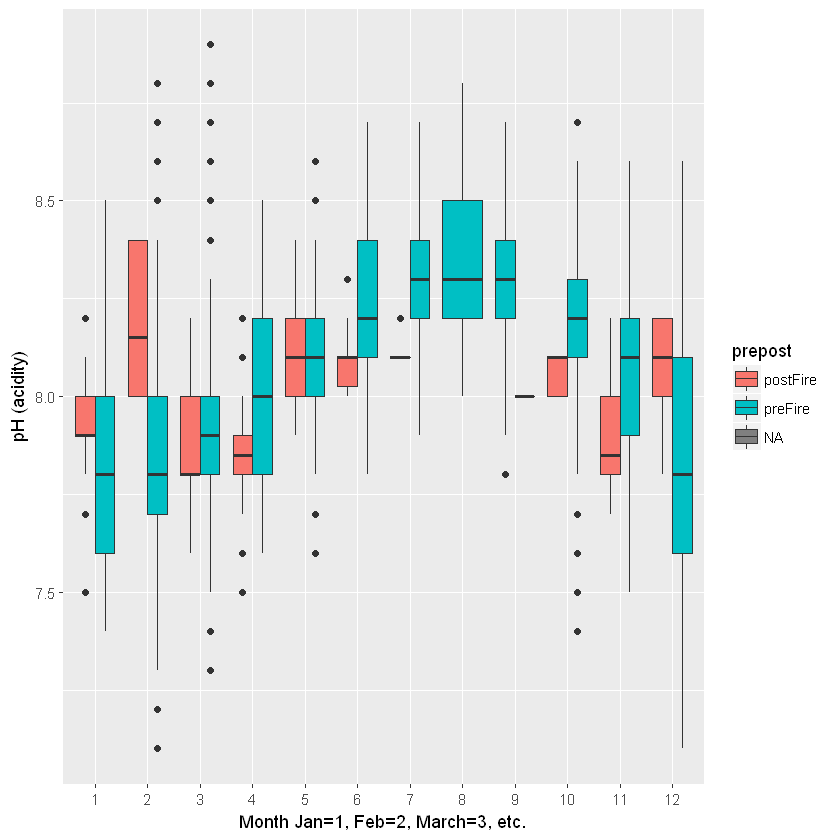

In [9]:

#############################Color the box plot by pre-post fire and combine by month

# grouped boxplot
ggplot(DailypH_1, aes(x=as.factor(Month), y=pH, fill=prepost)) + 
  geom_boxplot()+
  labs(x="Month Jan=1, Feb=2, March=3, etc.",y="pH (acidity)")

############################

## Mapping the USGS Data

### Set the input values and categorize the data

In [10]:
############=======Mapping pH for California Pre-Fire============##########


# Might take 1 minute to fetch the data. If this fails wait a moment and try again because everyone is trying to fetch at the same time
# CAUTION: do not run any additional lines of code until AllData is finished and the * goes away on the left. In[*]

startDate <- as.Date("2016-07-01")
endDate <- as.Date("2018-07-01")
AllData <- readWQPdata(statecode="CA",characteristicName="pH",startDate=startDate,endDate=endDate) 

unique(AllData$ResultMeasure.MeasureUnitCode) #we will use "None" units becuse pH is unitless
siteInfo <- attr(AllData, "siteInfo")





[1] "std units" "None"      NA          "mV"

In [11]:
head(AllData)

OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityTypeCode,ActivityMediaName,ActivityMediaSubdivisionName,ActivityStartDate,ActivityStartTime.Time,ActivityStartTime.TimeZoneCode,ActivityEndDate,...,LaboratoryName,AnalysisStartDate,ResultLaboratoryCommentText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure.MeasureValue,DetectionQuantitationLimitMeasure.MeasureUnitCode,PreparationStartDate,ProviderName,ActivityStartDateTime,ActivityEndDateTime
USGS-CA,USGS California Water Science Center,nwisca.01.01800559,Sample-Routine,Water,Groundwater,2017-11-15,10:40:00,PST,NA,...,U.S. Geological Survey-Water Resources Discipline,NA,NA,NA,NA,NA,NA,NWIS,2017-11-15 18:40:00,NA
USGS-CA,USGS California Water Science Center,nwisca.01.01800560,Sample-Routine,Water,Groundwater,2017-11-14,15:00:00,PST,NA,...,U.S. Geological Survey-Water Resources Discipline,NA,NA,NA,NA,NA,NA,NWIS,2017-11-14 23:00:00,NA
USGS-CA,USGS California Water Science Center,nwisca.01.01800562,Sample-Routine,Water,Groundwater,2017-11-13,16:10:00,PST,NA,...,U.S. Geological Survey-Water Resources Discipline,NA,NA,NA,NA,NA,NA,NWIS,2017-11-14 00:10:00,NA
USGS-CA,USGS California Water Science Center,nwisca.01.01800564,Sample-Routine,Water,Groundwater,2017-11-12,15:00:00,PST,NA,...,U.S. Geological Survey-Water Resources Discipline,NA,NA,NA,NA,NA,NA,NWIS,2017-11-12 23:00:00,NA
USGS-CA,USGS California Water Science Center,nwisca.01.01800566,Sample-Routine,Water,Groundwater,2017-11-11,15:30:00,PST,NA,...,U.S. Geological Survey-Water Resources Discipline,NA,NA,NA,NA,NA,NA,NWIS,2017-11-11 23:30:00,NA
USGS-CA,USGS California Water Science Center,nwisca.01.01800567,Sample-Routine,Water,Groundwater,2017-11-11,12:40:00,PST,NA,...,U.S. Geological Survey-Water Resources Discipline,NA,NA,NA,NA,NA,NA,NWIS,2017-11-11 20:40:00,NA


In [12]:
# Everything for wiSummary needs to be run as a group
# Put your cursor at the beginning of wiSummaryPre then press run.
# If an error pops up here it means you did not stop for AllData to finish and sitInfo did not run correctly. If the error arises, Close R studio, start rstudio fresh by "cleaning" or "sweeping" your workspace clean, load the libraries and move through the code slowly starting at the AllData line.

wiSummaryPre <- AllData %>%
  filter(ResultMeasure.MeasureUnitCode %in% c("None")) %>%
  group_by(MonitoringLocationIdentifier) %>%
  summarise(count=n(),
            start=min(ActivityStartDateTime),
            end=max(ActivityStartDateTime),
            mean = mean(ResultMeasureValue, na.rm = TRUE)) %>%
  #filter(count > 30) %>%
  arrange(-count) %>%
  left_join(siteInfo, by = "MonitoringLocationIdentifier")

indx<-which(is.na(wiSummaryPre$mean))
wiSummaryPre<-wiSummaryPre[-indx,]

In [13]:
head(wiSummaryPre)

MonitoringLocationIdentifier,count,start,end,mean,station_nm,agency_cd,site_no,dec_lat_va,dec_lon_va,...,CountyCode,AquiferName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure.MeasureValue,WellDepthMeasure.MeasureUnitCode,WellHoleDepthMeasure.MeasureValue,WellHoleDepthMeasure.MeasureUnitCode,ProviderName
MRSENVMB_WQX-M-001,730,2016-07-01 07:00:00,2018-06-30 07:00:00,7.362192,Treatment Plant Air Relief Structure,MRSENVMB_WQX,MRSENVMB_WQX-M-001,35.37972,-120.8611,...,079,NA,NA,NA,NA,NA,NA,NA,NA,STORET
MRSENVMB_WQX-M-INF,729,2016-07-01 07:00:00,2018-06-30 07:00:00,7.602469,Treatment Plant Headworks,MRSENVMB_WQX,MRSENVMB_WQX-M-INF,35.37910,-120.8601,...,079,NA,NA,NA,NA,NA,NA,NA,NA,STORET
MRSENVMB_WQX-RW5,230,2016-09-20 16:07:46,2018-03-12 17:02:23,8.031444,Downcoast Water Quality Nearfield,MRSENVMB_WQX,MRSENVMB_WQX-RW5,35.38612,-120.8751,...,079,NA,NA,NA,NA,NA,NA,NA,NA,STORET
MRSENVMB_WQX-RW4,229,2016-09-20 16:10:45,2018-03-12 16:59:02,8.026322,Downcoast Water Quality ZID,MRSENVMB_WQX,MRSENVMB_WQX-RW4,35.38647,-120.8751,...,079,NA,NA,NA,NA,NA,NA,NA,NA,STORET
MRSENVMB_WQX-RW3,227,2016-09-20 16:13:52,2018-03-12 16:55:46,8.025528,Upcoast Water Quality ZID,MRSENVMB_WQX,MRSENVMB_WQX-RW3,35.38683,-120.8751,...,079,NA,NA,NA,NA,NA,NA,NA,NA,STORET
MRSENVMB_WQX-RW6,227,2016-09-20 16:04:23,2018-03-12 17:06:02,8.036914,Downcoast Water Quality Midfield,MRSENVMB_WQX,MRSENVMB_WQX-RW6,35.38575,-120.8751,...,079,NA,NA,NA,NA,NA,NA,NA,NA,STORET


In [14]:
#Set the colors and the point sizes
col_types <- c("darkblue","dodgerblue","green4","gold1","orange","brown","red") #sets colors
leg_vals <- unique(as.numeric(quantile(wiSummaryPre$mean, probs=c(0,0.001,0.01,0.1,0.25,0.5,0.75,0.9,.99,1), na.rm=TRUE)))#sets legend values
pal = colorBin(col_types, wiSummaryPre$mean, bins = leg_vals) #creates a color ramp
rad <-4*seq(1,4,length.out = 16) #defines the range of values for point sizes
wiSummaryPre$sizes <- rad[as.numeric(cut(wiSummaryPre$count, breaks=16))]

## Run the leaflet interactive map

In [16]:
# Leaflet lines need to be run as a group
# Put your cursor at the beginning of leaflet and press run to show the map


m <- leaflet(data=wiSummaryPre) %>% 
  addProviderTiles("CartoDB.Positron") %>%
  addCircleMarkers(~dec_lon_va,~dec_lat_va,
                   fillColor = ~pal(mean),
                   radius = ~sizes,
                   fillOpacity = 0.8, opacity = 0.8,stroke=FALSE,
                   popup=paste("Site #", wiSummaryPre$station_nm, "<br>","Value:", wiSummaryPre$mean,"<br>","Type:",wiSummaryPre$MonitoringLocationTypeName)) %>%
  #popup=~station_nm) %>%
  addLegend(position = 'bottomleft',
            pal=pal,
            values=~mean,
            opacity = 0.8,
            labFormat = labelFormat(digits = 1), 
            title = 'Mean Value of pH ')

saveWidget(m, 'demo.html', selfcontained = FALSE)
display_html('<iframe width="1000" height="600" src="demo.html"></iframe>')



## What sources of water impact pH in a river? Drainage basin concepts:

When rain falls on the landscape, water will drain downward into the soil as a contribution to groundwater recharge, and it will also flow as runoff into the river. The water quality and quantify that we see and measure in a river is a mixture of these waters from runoff and recharge, and reflects a history of chemical conditions and reactions as it moves through or over the soil to the main-stem of the river.

When water runs off the burned landscape, it potentially causes debris flows, landslides, and leaches contaminated water into the aquifer and river.

This matters because pH is an important indicator of river health and impacts water quality. While young fish and insect larvae are sensitive to a low pH (acid), extreme values on either end of the scale (more basic) can be lethal to orgnaisms and impact biogeochemical cycles in the river and aquifer.

![Image of Drainage Basin](https://bit.ly/2L2PV1t)

## Major Research Questions Remain 



Question: What are the contributions of surface and groundwater flow to the water qualtiy we measure in the river?

Question: How will the fire impact the chemical conditions at other locations throughout the Russian River Watershed?

Question: What can our models reveal about how this system will respond to drought conditions? Will we see exagerrated impacts for example, if we get an atmospheric river that drives more runoff from the burned zones?



In [ ]:
# Thank you!
contact: mnewcomer@lbl.gov

https://eesa.lbl.gov/profiles/michelle-newcomer/